In [10]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from fppanalysis.running_moments import window_radius, run_norm_ds

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full

from velocity_estimation import two_dim_velocity_estimates as tdve
from velocity_estimation import utils as u
from  velocity_estimation import time_delay_estimation as td

### This code plots the poloidal averaged radial velocity component for either cross correlation or cross conditional average

In [3]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

In [5]:
cross_correlation_method = False

if cross_correlation_method:

    #-------------- Cross correlation ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CC

    use_3point_method = True
    ccf_min_lag = 1
    minimum_cc_value = 0
    running_mean = True

    eo.use_3point_method = True if use_3point_method == True else False
    eo.cc_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.cc_options.minimum_cc_value = minimum_cc_value

else:
        
    #-------------- Cross conditional average ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CA

    use_3point_method = True
    ccf_min_lag = 1
    running_mean = True
    plot_events = False
    ca_min = 2.5
    ca_max = np.inf

    eo.use_3point_method = True if use_3point_method == True else False
    eo.ca_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.ca_options.delta = 1.4e-4
    eo.ca_options.window = True
    eo.ca_options.min_threshold = ca_min
    eo.ca_options.max_threshold = ca_max

In [6]:
R_average = []
all_vx_av = []
all_vy_av = []
all_vx_vy = []
all_v = []

for idx, shot in enumerate(shotlist):

    f_GW = greenwald_fraction[shot]
    f_GW = '{:.2f}'.format(f_GW)
    path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
    ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')

    R_coordinates, Z_coordinates = get_rz_full(ds)

    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    sliced_ds = ds.sel(time=slice(t_start, t_end))
    radius = window_radius(1e3, sliced_ds.time)
    ds = run_norm_ds(sliced_ds, radius)

    movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
    vx = movie_data.get_vx()
    vy = movie_data.get_vy()
    confidences = movie_data.get_confidences()
    R = movie_data.get_R()
    Z = movie_data.get_Z()

    if shot == 1160616018 or shot == 1110201016:
        # Wave mode pixels
        # Create a 10x9 array filled with False
        wave_pixels_bool = np.full((10, 9), False, dtype=bool)

        # Set two innermost columns to True
        wave_pixels_bool[:, [0, 1]] = True

        if shot == 1110201016:
            wave_pixels_bool[0, 7] = True
            wave_pixels_bool[0, 8] = True

        # Mark dead and alive pixels
        true_indices_wave = np.where(wave_pixels_bool)
        vx[true_indices_wave] = np.nan
        vy[true_indices_wave] = np.nan
        confidences[true_indices_wave] = np.nan
        wave_pixels_R = R[true_indices_wave]
        wave_pixles_Z = Z[true_indices_wave]

    if shot == 1110201011:
        # Create a 10x9 array filled with False
        wave_pixels_bool = np.full((10, 9), False, dtype=bool)

        # Set the two innermost columns to True
        wave_pixels_bool[:, [0]] = True

        # Mark dead and alive pixels
        true_indices_wave = np.where(wave_pixels_bool)
        vx[true_indices_wave] = np.nan
        vy[true_indices_wave] = np.nan
        confidences[true_indices_wave] = np.nan
        wave_pixels_R = R[true_indices_wave]
        wave_pixles_Z = Z[true_indices_wave]

    # Take the average over all 10 columns, which results in an array of 9 velocities for each row
    vx_av = [np.nanmean(vx[:,i][np.argwhere(vx[:,i])]) / 100 for i in range(vx.shape[1])]
    vy_av = [np.nanmean(vy[:,i][np.argwhere(vy[:,i])]) / 100 for i in range(vy.shape[1])]
    all_vx_av.append(vx_av)
    all_vy_av.append(vy_av)

    # Divide vx components by vy components to get the ratio
    all_vx_vy.append([i / j for i, j in zip(vx_av, vy_av)])

    # Compute the average velocity
    all_v.append([np.nanmean(np.sqrt(vx_av[i]**2 + vy_av[i]**2)) for i in range(len(vx_av))])

    # Averaging over the 9 columns
    radial_average = np.nanmean(all_vx_av[idx][4:8])
    R_average.append(radial_average)

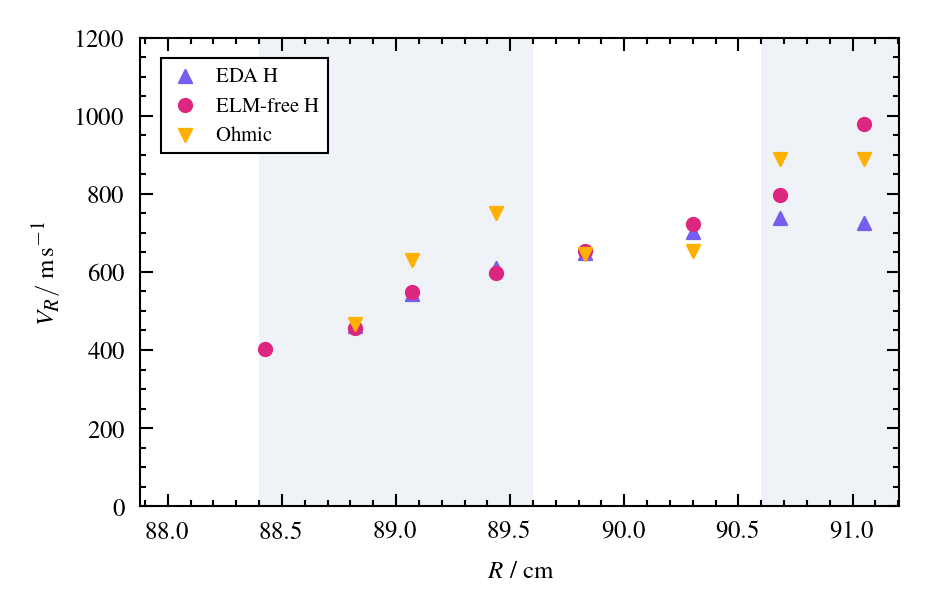

In [18]:
save = False

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["font.size"] = 6
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5

fig = plt.figure()
ax = fig.add_axes(axes_size)

# Average greenwald fraction
for idx, shot in enumerate(shotlist):
    ax.scatter(R[0], all_vx_av[idx], label=label_name[idx], color=color_list[idx], marker=marker_list[idx], s=10)


# Shaded area for LCFS and limiter
ax.axvspan(88.4, 89.6, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.axvspan(90.6, 91.5, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.set_xlim(left=R[0][0]-0.15, right=R[0][-1]+0.15)
ax.set_ylim(bottom=0, top=1200)
ax.legend(loc='upper left', borderaxespad=1)
ax.set_xlabel(r"$R$ / cm")
ax.set_ylabel(r"$V_{R} / \hspace{0.25em} \mathrm{m} \hspace{0.1em} \mathrm{s}^{-1}$")
# ax1.legend(loc='upper left', bbox_to_anchor=(1.03, 1.03))
plt.show()

if save == True:
    format = "pdf"
    foldername = '/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
    if cross_correlation_method:
        filename = f'velocity_profile_ccf_{shotlist[0]}_{shotlist[1]}_{shotlist[2]}.{format}'
    else:
        filename = f'velocity_profile_cca_{shotlist[0]}_{shotlist[1]}_{shotlist[2]}.{format}'
    fig.savefig(foldername + filename, bbox_inches="tight", format=format)